# Results for experiments with Co-embeddings

In [1]:
%matplotlib inline
import numpy
import pandas
import pickle
import os
import re

from sklearn import metrics

In [2]:
import seaborn
seaborn.set_style('white')

In [3]:
def get_runs(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'prediction' in run_prediction]

def get_learning(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'performance' in run_prediction]

In [4]:
def base_metrics_df():
    return pandas.DataFrame(columns=['Experiment', 'Run',
                                     'AUC-mean', 'RMSE-mean', 'APS-mean', 'Accuracy-mean', 'R2-mean',
                                     'AUC-std', 'RMSE-std', 'APS-std', 'Accuracy-std', 'R2-std'])

In [5]:
def read_file_metrics(filename):
    """Returns a DataFrame with values Sequence length, AUC, RMSE, APS, Accuracy, R2 Score"""
    results = []
    ignored_sequences = 0
    with open(filename, 'rb') as prediction_file:
        true, predicted = pickle.load(prediction_file)
    for true_sequence, predicted_sequence in zip(true, predicted):
        results.append([true_sequence.shape[0]])
        try:
            results[-1].append(metrics.roc_auc_score(true_sequence, predicted_sequence))
        except ValueError:
            ignored_sequences += 1
            results[-1].append(numpy.nan)
        results[-1].append(metrics.mean_squared_error(true_sequence, predicted_sequence)**0.5)
        results[-1].append(metrics.average_precision_score(true_sequence, predicted_sequence))
        results[-1].append(metrics.accuracy_score(true_sequence, numpy.where(predicted_sequence > 0.5, 1, 0)))
        results[-1].append(metrics.r2_score(true_sequence, predicted_sequence))
        
    print('{} sequences with only one class, ignoring.'.format(ignored_sequences))
    return pandas.DataFrame(results, columns=['Sequence lenght', 'AUC', 'RMSE', 'APS', 'Accuracy', 'R2'])

In [6]:
def read_averaged_metrics(filename, metrics_df, columns=['AUC', 'RMSE', 'APS', 'Accuracy', 'R2']):
    """Generates a single dataset with the mean and std by sequence of metrics dataframes."""
    results = {}
    file_metrics = read_file_metrics(filename)
    results['Experiment'] = filename.split('/')[:-2]
    results['Run'] = re.search('.*run(\d+).*', filename).group(1)
    for column in columns:
        results[column + '-mean'] = file_metrics[column].mean()
        results[column + '-std'] = file_metrics[column].std()
    metrics_df.loc[metrics_df.shape[0]] = results
    return metrics_df

In [7]:
def raw_metrics(dirnames):
    metrics_dfs = []
    for dirname in dirnames:
        for filename in get_runs(dirname):
            file_metrics = read_file_metrics(os.path.join(dirname, filename))
            file_metrics['Experiment'] = dirname[-16:]
            file_metrics['Run'] = re.search('.*run(\d+).*', filename).group(1)
            metrics_dfs.append(file_metrics)
    return pandas.concat(metrics_dfs, ignore_index=True)

In [8]:
def averaged_metrics(dirnames):
    metrics_df = base_metrics_df()
    for dirname in dirnames:
        for filename in get_runs(dirname):
            metrics_df = read_averaged_metrics(os.path.join(dirname, filename), metrics_df)
    return metrics_df

In [9]:
EXPERIMENTS_DIRS = [
    '/home/mteruel/edm/results/dkt_lstm/coembeddings/predictions/17-12-18-10-34/',
    '/home/mteruel/edm/results/dkt_lstm/coembeddings/predictions/17-12-18-14-27/',
    '/home/mteruel/edm/results/dkt_lstm/coembeddings/predictions/17-12-18-22-49/',
]

## Learning curves

In [12]:
def read_performances(dirnames):
    results = {}
    for dirname in reversed(dirnames):
        dataframes = []
        for filename in get_learning(dirname):
            with open(os.path.join(dirname, filename), 'rb') as performance_file:
                train, validation = pickle.load(performance_file)
            train = pandas.DataFrame(train, columns=['epoch', 'mse'])
            validation = pandas.DataFrame(validation, columns=['epoch', 'mse'])
            train['Dataset'] = 'train'
            train['Run'] = re.search('.*run(\d+).*', filename).group(1)
            validation['Dataset'] = 'validation'
            validation['Run'] = re.search('.*run(\d+).*', filename).group(1)
            dataframes.append(pandas.concat([train, validation]))
        if len(dataframes) > 0:
            results[dirname] = pandas.concat(dataframes) # train.join(validation, lsuffix='_t', rsuffix='_v')
    return results

def graphic_performances(train_performances):
    for dirname, performance_dataframe in train_performances.items():
        print(dirname)
        grid = seaborn.FacetGrid(data=performance_dataframe,
                                 col='Run', despine=True, ylim=[0, 0.3], aspect=1.5, col_wrap=2,
                                 palette='colorblind')
        grid.map(seaborn.pointplot, 'epoch', 'mse', 'Dataset').add_legend()

In [13]:
performances = read_performances(EXPERIMENTS_DIRS)

/home/mteruel/edm/results/dkt_lstm/coembeddings/predictions/17-12-18-22-49/


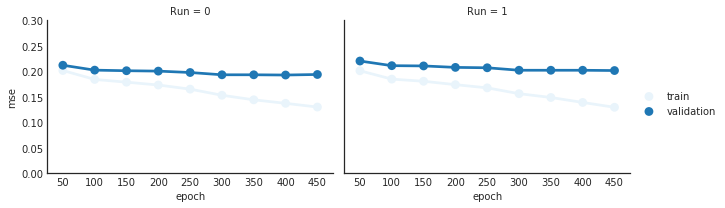

In [14]:
graphic_performances(performances)

## Performance Metrics not averaged by sequence

In [15]:
raw_results = raw_metrics(EXPERIMENTS_DIRS)

126 sequences with only one class, ignoring.
107 sequences with only one class, ignoring.
115 sequences with only one class, ignoring.
109 sequences with only one class, ignoring.
115 sequences with only one class, ignoring.
96 sequences with only one class, ignoring.
111 sequences with only one class, ignoring.


In [16]:
raw_results.groupby(['Experiment', 'Run']).agg(['mean', 'std'])

Sequence lenght                   AUC            \
                                mean         std      mean       std   
Experiment       Run                                                   
/17-12-18-10-34/ 0          78.37000  149.590465  0.674602  0.164167   
                 1          78.38625  162.313113  0.680171  0.170252   
                 2          81.13875  164.053738  0.696349  0.150736   
/17-12-18-14-27/ 0          73.54000  150.403657  0.691354  0.169238   
                 1          73.33125  147.465204  0.703371  0.164231   
/17-12-18-22-49/ 0          63.69875  131.645722  0.700750  0.181902   
                 1          84.75625  164.116657  0.695746  0.163973   

                          RMSE                 APS            Accuracy  \
                          mean       std      mean       std      mean   
Experiment       Run                                                     
/17-12-18-10-34/ 0    0.471824  0.174517  0.833619  0.149883  0.700027   
                 1    0.469313  0.173203  0.837580  0.146447  0.700915   
                 2    0.468054  0.172294  0.838499  0.145092  0.702198   
/17-12-18-14-27/ 0    0.423270  0.141857  0.846865  0.141434  0.712282   
                 1    0.426447  0.140355  0.843563  0.148876  0.708705   
/17-12-18-22-49/ 0    0.419723  0.137192  0.855071  0.136466  0.716815   
                 1    0.417762  0.125550  0.841723  0.139541  0.716019   

                                      R2            
                           std      mean       std  
Experiment       Run                                
/17-12-18-10-34/ 0    0.153134 -0.468013  0.776245  
                 1    0.153069 -0.502416  0.991415  
                 2    0.147879 -0.393681  0.646501  
/17-12-18-14-27/ 0    0.153858 -0.225474  0.738529  
                 1    0.155382 -0.262594  0.958991  
/17-12-18-22-49/ 0    0.162803 -0.212858  0.790940  
                 1    0.149547 -0.169123  0.628875

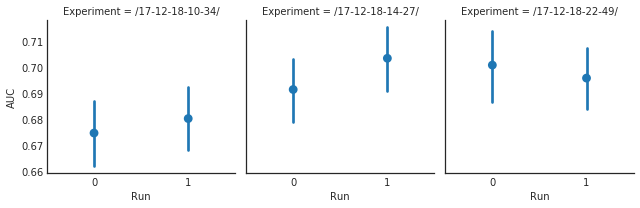

In [17]:
grid = seaborn.FacetGrid(data=raw_results, col='Experiment')
grid.map(seaborn.pointplot, 'Run', 'AUC', join=False)

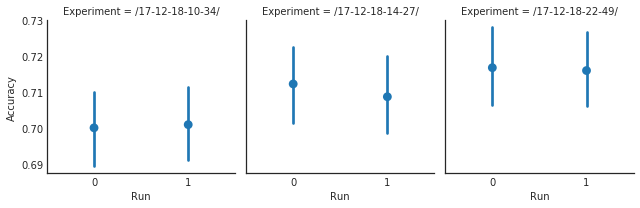

In [75]:
grid = seaborn.FacetGrid(data=raw_results, col='Experiment')
grid.map(seaborn.pointplot, 'Run', 'Accuracy', join=False)

## Performance Metrics averaged by sequence

In [76]:
averaged_results = averaged_metrics(EXPERIMENTS_DIRS)

126 sequences with only one class, ignoring.
107 sequences with only one class, ignoring.
115 sequences with only one class, ignoring.
109 sequences with only one class, ignoring.
115 sequences with only one class, ignoring.
96 sequences with only one class, ignoring.
111 sequences with only one class, ignoring.


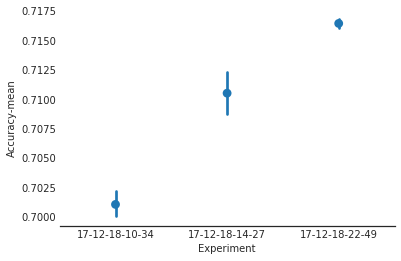

In [77]:
seaborn.pointplot(data=averaged_results, x='Experiment', y='Accuracy-mean', join=False)
seaborn.despine(left=True)

In [78]:
lala = averaged_results.groupby('Experiment')
lala.aggregate('mean')

,AUC-mean,RMSE-mean,APS-mean,Accuracy-mean,R2-mean,AUC-std,RMSE-std,APS-std,Accuracy-std,R2-std
Experiment,,,,,,,,,,
17-12-18-10-34,0.683707,0.469731,0.836566,0.701047,-0.454703,0.161718,0.173338,0.147141,0.151361,0.804720
17-12-18-14-27,0.697363,0.424859,0.845214,0.710493,-0.244034,0.166734,0.141106,0.145155,0.154620,0.848760
17-12-18-22-49,0.698248,0.418742,0.848397,0.716417,-0.190990,0.172937,0.131371,0.138003,0.156175,0.709907


## Performance metrics not averaged

In [12]:
def get_not_averaged_metrics(dirnames):
    """Returns the metrics not averaged by student sequence"""
    results = []
    for dirname in reversed(dirnames):
        for filename in get_runs(dirname):
            results.append([dirname.split('/')[-2]])
            results[-1].append(re.search('.*run(\d+).*', filename).group(1))
            with open(os.path.join(dirname, filename), 'rb') as prediction_file:
                true, predicted = pickle.load(prediction_file)

            # Flatten the sequences
            true_sequence = numpy.array([x for sequence in true for x in sequence])
            predicted_sequence = numpy.array([x for sequence in predicted for x in sequence])

            results[-1].append(metrics.roc_auc_score(true_sequence, predicted_sequence))
            results[-1].append(metrics.mean_squared_error(true_sequence, predicted_sequence)**0.5)
            results[-1].append(metrics.average_precision_score(true_sequence, predicted_sequence))
            results[-1].append(metrics.accuracy_score(true_sequence, numpy.where(predicted_sequence > 0.5, 1, 0)))
            results[-1].append(metrics.r2_score(true_sequence, predicted_sequence))

    return pandas.DataFrame(results, columns=['Experiment', 'Run', 'AUC', 'RMSE', 'APS', 'Accuracy', 'R2'])

In [13]:
not_averaged_results = get_not_averaged_metrics(EXPERIMENTS_DIRS)
not_averaged_results.groupby('Experiment').mean()

,AUC,RMSE,APS,Accuracy,R2
Experiment,,,,,
17-12-18-10-34,0.709289,0.514457,0.811769,0.683655,-0.171805
17-12-18-14-27,0.720858,0.460571,0.825749,0.693467,0.060778
17-12-18-22-49,0.729384,0.447143,0.835851,0.705750,0.106353


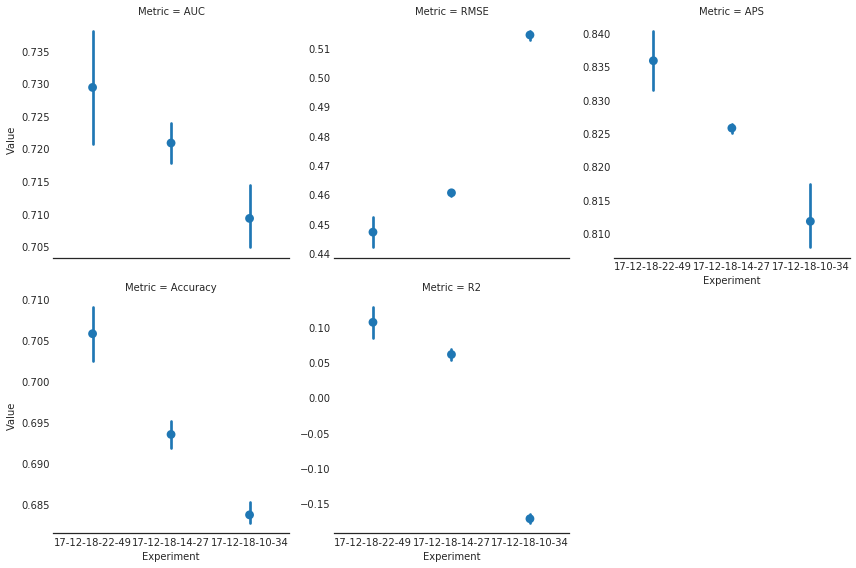

In [14]:
seaborn.factorplot(
    data=not_averaged_results.set_index(['Experiment', 'Run']).stack().reset_index().rename(
        columns={'level_2': 'Metric', 0: 'Value'}), x='Experiment', y='Value', col='Metric', sharey=False,
    col_wrap=3, join=False)
seaborn.despine(left=True)

In [47]:
seabor

,Experiment,Run,Metric,Value
0,17-12-18-22-49,1,AUC,0.738012
1,17-12-18-22-49,1,RMSE,0.442103
2,17-12-18-22-49,1,APS,0.840279
3,17-12-18-22-49,1,Accuracy,0.709033
4,17-12-18-22-49,1,R2,0.128298
5,17-12-18-22-49,0,AUC,0.720756
6,17-12-18-22-49,0,RMSE,0.452184
7,17-12-18-22-49,0,APS,0.831422
8,17-12-18-22-49,0,Accuracy,0.702467
9,17-12-18-22-49,0,R2,0.084409
